#Fantasy Team Project

##Project Description:

Who wants to win at Daily Fantasy Sports on Draftkings? Everybody? Anybody? Well, let’s be honest, this project isn’t going to make you win, but it is a fun optimization problem! And that’s really the point in this class.

Imagine that we were interested in joining one of the Draftkings’ National Basketball Association (NBA) contests on Feb 22, 2024. There were 12 real NBA games played amongst 24 teams. The fantasy contest involves selecting a collection of players (a lineup) in these 12 games and you “play” against other people that (potentially) selected different lineups. The winner of the contest is the person whose team accumulated the most fantasy points. The fantasy points are accumulated according to a set of rules (see Figure 1) that are related to how the players perform in their real-life games. Selecting a lineup is subject to a fictitious salary cap and several additional constraints that are outlined below. The goal of this project is to select an “optimal” lineup. What is “optimal?” That is for you to decide!  

Data
Here are the data that you need to solve this problem.
- 	DKSalaries.csv – Data from Draftkings website including player names, teams, salary, position, and average points per game.
- Actual game data from Feb 22, 2024
    - XXX.csv – Data from each of the 12 games on Feb 22 related to the players.
- Season Statistics
    - PlayerStats.csv – Data from the NBA season (October 24, 2023 through Feb 21, 2024)

Objectives:
1.	Use python to apply optimization models and solution techniques learned in class to solve a real-world problem.
2.	You will have to do some exploratory data analysis using the historical data to carefully consider your objective function coefficients.
3.	You will solve at least two optimization problems for this project:

  a.	One problem will involve selecting a lineup based on historical information. Tell me what your strategy was in choosing players, and how it would outperform the naïve strategy of picking just based on average daily points.  Perhaps older players will play better than they averaged because these players had a lot of rest?  Maybe players do better at home than on the road?  Maybe players do better if they are playing against a bad team, or worse if they are playing against a good team? Maybe you want to pick people who are on the same team, because if one player is scoring, his teammate might be getting the assist?  If you don’t know anything about basketball, use Google (or your favorite AI)!

  b.	The second problem will involve selecting the optimal lineup based on how the players performed during their actual games (i.e., the “cheat code” if you had it prior to selecting your lineup.

4.	Write a report summarizing your results.


#Downloading and Importing Packages
We will be using pandas, pyomo, matplotlib, and unicode data for this model. These packages are tools that will allow us to manipulate the data we will be using for our problem.

In [ ]:
!pip install pyomo
!apt-get install -y -qq glpk-utils

import pandas as pd
import pyomo.environ as pe
import matplotlib.pyplot as plt
import unicodedata

import os
from google.colab import drive
drive.mount('/content/drive')
os.chdir("/content/drive/My Drive/Colab Notebooks/Optimization Project")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Load the Data
We will need to upload the data from three different files: 'PlayerStats.csv', 'DKSalaries.csv', and 'Feb22NBAStats.xlsx'. Here is a data dictionary of all the different columns and what they record:

File: DKSalaries.csv
Columns/Variables:
1.	Position – The player’s position in the game.
2.	Name + ID – Player name plus their ID in Draftkings
3.	Name – Player name
4.	ID – Player ID in Draftkings
5.	Roster Position – All the legitimate positions that this player can fill in your Draftkings fantasy roster. Note that all players can also be considered for the utility (Util) position.
6.	Salary – Player salary in the game. Remember that each fantasy team roster in Draftkings may not exceed $50,000 in total salary.
7.	Game Info – General information related to the game including teams that are playing, time of game, etc.
8.	TeamAbbrev – The player’s team name (abbreviated).
9.	AvgPointsPerGame – The average Draftkings points for the player in each game up to this point in the season.

File: PlayerStats.csv (and the final stats data)
Columns/Variables:
1.	Rank – the player’s rank for the year in terms of number of points scored for the season
2.	player – player name
3.	pos – player position
4.	age – player’s age
5.	Tm – player’s team
6.	g – games played in the data set (note that this should only be one in this data set)
7.	gs – games started
8.	mp – minutes played
9.	FG – number of shots (field goals) made
10.	FGA – number of shots (field goals) attempted
11.	FG% - field goal percentage.  Calculated as (FG/FGA)
12.	3P – number of Three-point shots made
13.	3PA – number of Three-point shots attempted
14.	3P% - Three-point shot percentage.  Calculated as (3P/3PA)
15.	2P – number of Two-point shots made
16.	2PA – number of Two-point shots attempted
17.	2P% - Two-point shot percentage.  Calculated as (2P/2PA)
18.	Efg% - effective field goal percentage = (FG + (0.5*3P))/FGA.  This statistic weights Three-point shots as 50% more than Two-point shots.  A Three-point shot obviously scores 50% more points than a Two-point shot, but it is also more difficult to make as they are much further from the basket.
19.	FT – free throws made
20.	FTA – free throws attempted
21.	FT% - free thrown percentage, calculated as (FT/FTA)
22.	ORB – offensive rebounds
23.	DRB – defensive rebounds
24.	TRB – total rebounds, calculated as (ORB + DRB)
25.	AST – total assists
26.	STL – total steals
27.	BLK – total shots blocked
28.	TOV – total turnovers (times this player gave the ball to the other team, by losing it, or throwing it out of bounds, or having it stolen from them)
29.	PF – personal fouls
30.	PTS – total points scored.  Calculated as (FT + 2*2P + 3*3P)

The 'Feb22NBAStats.xlsx' records the same statistics, but only for the February 22 games.



In [ ]:
df_PlayerStats = pd.read_csv('PlayerStats.csv')
df_PlayerStats

,Rk,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,...,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,Player-additional
0,1,Shai Gilgeous-Alexander,PG,25,OKC,53,53,1831,580,1063,...,48,245,293,346,115,47,114,134,1649,gilgesh01
1,2,Giannis Antetokounmpo,PF,29,MIL,53,53,1852,611,1000,...,136,466,602,334,73,58,187,158,1627,antetgi01
2,3,Luka Dončić,PG,24,DAL,47,47,1760,542,1102,...,35,380,415,448,68,29,186,93,1606,doncilu01
3,4,Jalen Brunson,PG,27,NYK,52,52,1865,511,1059,...,30,169,199,336,48,10,123,105,1434,brunsja01
4,5,Jayson Tatum,PF,25,BOS,52,52,1860,481,1012,...,46,399,445,249,52,31,130,104,1411,tatumja01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
535,536,Micah Potter,PF,25,UTA,2,0,7,0,1,...,0,4,4,0,0,0,0,0,0,pottemi01
536,537,Jason Preston,PG,24,UTA,1,0,1,0,0,...,1,0,1,0,0,0,1,0,0,prestja01
537,538,Dmytro Skapintsev,C,25,NYK,2,0,2,0,1,...,0,0,0,0,0,0,0,0,0,skapidm01
538,539,Javonte Smart,PG,24,PHI,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,smartja01


#Data Cleaning Steps (Player Stats)

Data cleaning is a crucial step in preparing to solve our problem. In this case, we have tables that contain detailed statistics about NBA players. This tables include information like the player's name, position, age, team, and various performance metrics across all games.

Since we already loaded the data above, let's just focus on what you will see below.

The first step is to inspect the data. We take a look at the data to understand its structure. Data structure is a fancy way of saying we're checking how many rows and columns the table has, what type of information it contains (letters or numbers), and we also look for any missing pieces of information.

In [ ]:
# Initial Overview
print("Initial DataFrame info:")
df_PlayerStats.info()
print("\nInitial missing values per column:")
print(df_PlayerStats.isnull().sum())
print("\nUnique positions before cleaning:", df_PlayerStats['Pos'].unique())

Initial DataFrame info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 540 entries, 0 to 539
Data columns (total 31 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Rk                 540 non-null    int64  
 1   Player             540 non-null    object 
 2   Pos                540 non-null    object 
 3   Age                540 non-null    int64  
 4   Tm                 540 non-null    object 
 5   G                  540 non-null    int64  
 6   GS                 540 non-null    int64  
 7   MP                 540 non-null    int64  
 8   FG                 540 non-null    int64  
 9   FGA                540 non-null    int64  
 10  FG%                533 non-null    float64
 11  3P                 540 non-null    int64  
 12  3PA                540 non-null    int64  
 13  3P%                495 non-null    float64
 14  2P                 540 non-null    int64  
 15  2PA                540 non-null    int64  
 16  2P

#Normalizing Player's Names

Player names might be written in different formats, especially if they contain special characters from languages other than English (for example, Luka Dončić). We ensure all names are standardized toa  simple format without special characters, which makes them easier to work with.

###Handling Missing Values

The second half of the code block prints the number of missing values after normalizing the player's names. We have to deal with this as it may cause issues. Missing values are the equivalent of empty cells in an Excel spreadsheet. Therefore, we must check where these blanks are to decided how to handlethem. We can either remove the rows (if there is too much missing information in it) or fill in the blank spaces with default values.

In [ ]:
# Normalize player names directly using a lambda function
print("\nNormalizing player names...")
df_PlayerStats['Player'] = df_PlayerStats['Player'].apply(lambda x: unicodedata.normalize('NFKD', x).encode('ascii', 'ignore').decode('ascii'))

# Check for missing values and decide on an approach based on the output
# For demonstration, let's just print the missing values before any handling
print("\nMissing values after name normalization but before any handling:")
print(df_PlayerStats.isnull().sum())


Normalizing player names...

Missing values after name normalization but before any handling:
Rk                    0
Player                0
Pos                   0
Age                   0
Tm                    0
G                     0
GS                    0
MP                    0
FG                    0
FGA                   0
FG%                   7
3P                    0
3PA                   0
3P%                  45
2P                    0
2PA                   0
2P%                  14
eFG%                  7
FT                    0
FTA                   0
FT%                  47
ORB                   0
DRB                   0
TRB                   0
AST                   0
STL                   0
BLK                   0
TOV                   0
PF                    0
PTS                   0
Player-additional     0
dtype: int64


#Dropping Unnecessary Columns

If our table contains information we don't need, we simply just get rid of it. This is done to simplify our dataset!

In [ ]:
# Drop the 'Player-additional' column if it's not necessary for your analysis
print("\nDropping 'Player-additional' column...")
df_PlayerStats = df_PlayerStats.drop(columns=['Player-additional'])


Dropping 'Player-additional' column...


#Converting Datatypes

We have to make sure that each column in our table is of the right type of value for analysis. For example, player ages should be of the type numbers (integers). That way, we can perform any mathematical operation like finding the average age!

In [ ]:
# Convert 'Age' to integer directly (assuming it's safe to do so)
print("\nConverting 'Age' to integer...")
df_PlayerStats['Age'] = df_PlayerStats['Age'].astype(int)


Converting 'Age' to integer...


#Final Overview of the Data Cleaning Steps

After cleaning, we inspect the data to ensure everything looks correct so that we can perform our analysis. In the output below, we look at Dtype and at Columns, and match them to the correct Dtype. If they don't then we did something wrong. However, below we see that Age is of int64 (an integer, or a number). Other metrics such as MP (minutes played) is also of int64. Field goal percentage is a decimal number, and these are called float numbers in most programming languages. We can look at any metric that is measured in percentage and match it to a float64 data type.

After doing that, we are ready to perform our analysis. But first, let's clean the rest of the data!

In [ ]:
# Final Overview
print("\nFinal DataFrame info:")
df_PlayerStats.info()
print("\nMissing values after all cleaning steps:")
print(df_PlayerStats.isnull().sum())
print("\nUnique positions after cleaning:", df_PlayerStats['Pos'].unique())


Final DataFrame info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 540 entries, 0 to 539
Data columns (total 30 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Rk      540 non-null    int64  
 1   Player  540 non-null    object 
 2   Pos     540 non-null    object 
 3   Age     540 non-null    int64  
 4   Tm      540 non-null    object 
 5   G       540 non-null    int64  
 6   GS      540 non-null    int64  
 7   MP      540 non-null    int64  
 8   FG      540 non-null    int64  
 9   FGA     540 non-null    int64  
 10  FG%     533 non-null    float64
 11  3P      540 non-null    int64  
 12  3PA     540 non-null    int64  
 13  3P%     495 non-null    float64
 14  2P      540 non-null    int64  
 15  2PA     540 non-null    int64  
 16  2P%     526 non-null    float64
 17  eFG%    533 non-null    float64
 18  FT      540 non-null    int64  
 19  FTA     540 non-null    int64  
 20  FT%     493 non-null    float64
 21  ORB     540 non-

In [ ]:
# Display the first few rows of the DataFrame to visually inspect changes
print("\nFirst few rows after all cleaning steps:")
print(df_PlayerStats.head())


First few rows after all cleaning steps:
   Rk                   Player Pos  Age   Tm   G  GS    MP   FG   FGA  ...  \
0   1  Shai Gilgeous-Alexander  PG   25  OKC  53  53  1831  580  1063  ...   
1   2    Giannis Antetokounmpo  PF   29  MIL  53  53  1852  611  1000  ...   
2   3              Luka Doncic  PG   24  DAL  47  47  1760  542  1102  ...   
3   4            Jalen Brunson  PG   27  NYK  52  52  1865  511  1059  ...   
4   5             Jayson Tatum  PF   25  BOS  52  52  1860  481  1012  ...   

     FT%  ORB  DRB  TRB  AST  STL  BLK  TOV   PF   PTS  
0  0.883   48  245  293  346  115   47  114  134  1649  
1  0.655  136  466  602  334   73   58  187  158  1627  
2  0.777   35  380  415  448   68   29  186   93  1606  
3  0.835   30  169  199  336   48   10  123  105  1434  
4  0.824   46  399  445  249   52   31  130  104  1411  

[5 rows x 30 columns]


#Load Salary Data

In [ ]:
df_DKSalaries = pd.read_csv('DKSalaries.csv')
df_DKSalaries

,Position,Name + ID,Name,ID,Roster Position,Salary,Game Info,TeamAbbrev,AvgPointsPerGame
0,PG,Luka Doncic (32706645),Luka Doncic,32706645,PG/G/UTIL,12100,PHX@DAL 02/22/2024 07:30PM ET,DAL,65.18
1,C,Nikola Jokic (32706648),Nikola Jokic,32706648,C/UTIL,11600,WAS@DEN 02/22/2024 09:00PM ET,DEN,59.82
2,C,Joel Embiid (32706650),Joel Embiid,32706650,C/UTIL,11000,NYK@PHI 02/22/2024 07:00PM ET,PHI,63.90
3,PG,Shai Gilgeous-Alexander (32706652),Shai Gilgeous-Alexander,32706652,PG/G/UTIL,10500,LAC@OKC 02/22/2024 08:00PM ET,OKC,53.66
4,PF,Kevin Durant (32706655),Kevin Durant,32706655,PF/F/UTIL,10000,PHX@DAL 02/22/2024 07:30PM ET,PHX,49.34
...,...,...,...,...,...,...,...,...,...
337,C,Jock Landale (32707714),Jock Landale,32707714,C/UTIL,3000,HOU@NOP 02/22/2024 08:00PM ET,HOU,7.11
338,C,Boban Marjanovic (32707716),Boban Marjanovic,32707716,C/UTIL,3000,HOU@NOP 02/22/2024 08:00PM ET,HOU,6.39
339,PG,Nate Williams (32707718),Nate Williams,32707718,PG/G/UTIL,3000,HOU@NOP 02/22/2024 08:00PM ET,HOU,5.58
340,SG,Reggie Bullock Jr. (32707721),Reggie Bullock Jr.,32707721,SG/G/UTIL,3000,HOU@NOP 02/22/2024 08:00PM ET,HOU,5.88


#Data Cleaning Steps for Salaries

In [ ]:
# Assuming df_DKSalaries is already loaded

# Normalize player names
df_DKSalaries['Name'] = df_DKSalaries['Name'].apply(lambda x: unicodedata.normalize('NFKD', x).encode('ascii', 'ignore').decode('ascii'))

# Check for missing values and decide on an approach
# Example: Fill missing AvgPointsPerGame with the column's mean
df_DKSalaries['AvgPointsPerGame'].fillna(df_DKSalaries['AvgPointsPerGame'].mean(), inplace=True)

# Convert 'Salary' to integer
df_DKSalaries['Salary'] = df_DKSalaries['Salary'].astype(int)

# Additional steps would depend on inspecting the actual data and identifying specific needs for standardization and cleaning


In [ ]:
df_DKSalaries

,Position,Name + ID,Name,ID,Roster Position,Salary,Game Info,TeamAbbrev,AvgPointsPerGame
0,PG,Luka Doncic (32706645),Luka Doncic,32706645,PG/G/UTIL,12100,PHX@DAL 02/22/2024 07:30PM ET,DAL,65.18
1,C,Nikola Jokic (32706648),Nikola Jokic,32706648,C/UTIL,11600,WAS@DEN 02/22/2024 09:00PM ET,DEN,59.82
2,C,Joel Embiid (32706650),Joel Embiid,32706650,C/UTIL,11000,NYK@PHI 02/22/2024 07:00PM ET,PHI,63.90
3,PG,Shai Gilgeous-Alexander (32706652),Shai Gilgeous-Alexander,32706652,PG/G/UTIL,10500,LAC@OKC 02/22/2024 08:00PM ET,OKC,53.66
4,PF,Kevin Durant (32706655),Kevin Durant,32706655,PF/F/UTIL,10000,PHX@DAL 02/22/2024 07:30PM ET,PHX,49.34
...,...,...,...,...,...,...,...,...,...
337,C,Jock Landale (32707714),Jock Landale,32707714,C/UTIL,3000,HOU@NOP 02/22/2024 08:00PM ET,HOU,7.11
338,C,Boban Marjanovic (32707716),Boban Marjanovic,32707716,C/UTIL,3000,HOU@NOP 02/22/2024 08:00PM ET,HOU,6.39
339,PG,Nate Williams (32707718),Nate Williams,32707718,PG/G/UTIL,3000,HOU@NOP 02/22/2024 08:00PM ET,HOU,5.58
340,SG,Reggie Bullock Jr. (32707721),Reggie Bullock Jr.,32707721,SG/G/UTIL,3000,HOU@NOP 02/22/2024 08:00PM ET,HOU,5.88


#Load Feb. 22 Games Data

In [ ]:
df_FebStats = pd.read_excel('Feb22NBAStats.xlsx')
df_FebStats

,Rk,Player,Date,Age,Team,Unnamed: 5,Opp,Result,Starter,MP,...,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,Pos.
0,1,Luka Dončić,2024-02-22,24-359,DAL,NaN,PHO,W 123-113,*,38,...,0,9,9,11,3,0,3,4,41,G-F
1,2,Devin Booker,2024-02-22,27-115,PHO,@,DAL,L 113-123,*,39,...,1,4,5,8,1,0,4,2,35,G
2,3,Tyrese Maxey,2024-02-22,23-110,PHI,NaN,NYK,L 96-110,*,40,...,1,5,6,5,0,0,4,1,35,G
3,4,Stephen Curry,2024-02-22,35-345,GSW,NaN,LAL,W 128-110,*,32,...,0,1,1,8,3,0,1,1,32,G
4,5,Devin Vassell,2024-02-22,23-183,SAS,@,SAC,L 122-127,*,37,...,0,1,1,7,0,0,1,1,32,G-F
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,196,Miles McBride,2024-02-22,23-167,NYK,@,PHI,W 110-96,NaN,17,...,1,1,2,1,1,0,0,0,4,G
196,197,Sam Merrill,2024-02-22,27-283,CLE,NaN,ORL,L 109-116,NaN,12,...,1,1,2,4,0,0,0,0,4,G
197,198,Vasilije Micić,2024-02-22,30-040,CHO,@,UTA,W 115-107,NaN,20,...,1,1,2,8,0,0,2,3,4,G
198,199,Moses Moody,2024-02-22,21-267,GSW,NaN,LAL,W 128-110,NaN,20,...,1,5,6,1,0,0,0,2,4,G


#Data Cleaning for the Feb. 22 Games Stats

In [ ]:
# Normalize player names to remove special characters
df_FebStats['Player'] = df_FebStats['Player'].apply(lambda x: unicodedata.normalize('NFKD', x).encode('ascii', 'ignore').decode('ascii'))

# Convert 'Date' column to datetime format
df_FebStats['Date'] = pd.to_datetime(df_FebStats['Date'])

# Handle 'Unnamed: 5' column to indicate home/away games more clearly
df_FebStats['Home/Away'] = df_FebStats['Unnamed: 5'].apply(lambda x: 'Away' if x == '@' else 'Home')

# Drop the 'Unnamed: 5' column as it's no longer needed
df_FebStats.drop(columns=['Unnamed: 5'], inplace=True)

# Clean up the 'Pos.' column name to 'Pos' for consistency
df_FebStats.rename(columns={'Pos.': 'Pos'}, inplace=True)

# Assuming 'Age' needs to be converted to just years for simplicity, ignoring the days part
df_FebStats['Age'] = df_FebStats['Age'].apply(lambda x: int(x.split('-')[0]))

# Convert 'MP' (Minutes Played) to integers (assuming format is already suitable for conversion)
df_FebStats['MP'] = df_FebStats['MP'].astype(int)

# Fill missing values for numeric stats columns with zeros (e.g., ORB, DRB, TRB, etc.)
numeric_stats_columns = ['ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS']
df_FebStats[numeric_stats_columns] = df_FebStats[numeric_stats_columns].fillna(0)

# Assuming other specific cleaning steps based on the dataset's characteristics and the requirements of your analysis


In [ ]:
df_FebStats

,Rk,Player,Date,Age,Team,Opp,Result,Starter,MP,FG,...,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,Pos,Home/Away
0,1,Luka Doncic,2024-02-22,24,DAL,PHO,W 123-113,*,38,14,...,9,9,11,3,0,3,4,41,G-F,Home
1,2,Devin Booker,2024-02-22,27,PHO,DAL,L 113-123,*,39,13,...,4,5,8,1,0,4,2,35,G,Away
2,3,Tyrese Maxey,2024-02-22,23,PHI,NYK,L 96-110,*,40,11,...,5,6,5,0,0,4,1,35,G,Home
3,4,Stephen Curry,2024-02-22,35,GSW,LAL,W 128-110,*,32,12,...,1,1,8,3,0,1,1,32,G,Home
4,5,Devin Vassell,2024-02-22,23,SAS,SAC,L 122-127,*,37,13,...,1,1,7,0,0,1,1,32,G-F,Away
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,196,Miles McBride,2024-02-22,23,NYK,PHI,W 110-96,NaN,17,2,...,1,2,1,1,0,0,0,4,G,Away
196,197,Sam Merrill,2024-02-22,27,CLE,ORL,L 109-116,NaN,12,1,...,1,2,4,0,0,0,0,4,G,Home
197,198,Vasilije Micic,2024-02-22,30,CHO,UTA,W 115-107,NaN,20,1,...,1,2,8,0,0,2,3,4,G,Away
198,199,Moses Moody,2024-02-22,21,GSW,LAL,W 128-110,NaN,20,2,...,5,6,1,0,0,0,2,4,G,Home


#Problem A Data

It's crucial to understand Part A of our problem at hand. Our first problem is asking us to create a Fantasy League team based off historical data. Therefore, we don't need ANYTHING from the Feb. 22 games, since these are all statistics pertaining to a night of games. With that being said, we will ignore that dataset for now and focus on pulling data from the PlayerStats and DKSalaries datasets.

The PlayerStats records players metrics throughout the season (not including the February 22 games obviously). This historical data, or in other words the stats we have so far for the season, is what we will be using to come up with a team.



In [ ]:
# Assuming df_PlayerStats and df_DKSalaries are already loaded and prepared

# Merging necessary columns from df_PlayerStats and df_DKSalaries
# Including 'Game Info' and 'AvgPointsPerGame' from df_DKSalaries for more insights
master_df_q1 = pd.merge(
    df_PlayerStats[['Player', 'Pos', 'MP', 'PTS', '3P', 'TRB', 'AST', 'STL', 'BLK', 'TOV']],
    df_DKSalaries[['Name', 'Salary', 'Position', 'Game Info', 'AvgPointsPerGame']],
    left_on='Player',
    right_on='Name'
)

# Dropping the 'Name' column as it's a duplicate of 'Player'
master_df_q1.drop(columns=['Name'], inplace=True)

# Calculating Total Fantasy Points based on league's scoring rules
master_df_q1['Total Fantasy Points'] = (
    master_df_q1['PTS'] * 1 +      # Points
    master_df_q1['3P'] * 0.5 +     # 3-pointers
    master_df_q1['TRB'] * 1.25 +   # Total Rebounds
    master_df_q1['AST'] * 1.5 +    # Assists
    master_df_q1['STL'] * 2 +      # Steals
    master_df_q1['BLK'] * 2 +      # Blocks
    master_df_q1['TOV'] * (-0.5)   # Turnovers
)

# Displaying the first few rows of the master DataFrame
master_df_q1


,Player,Pos,MP,PTS,3P,TRB,AST,STL,BLK,TOV,Salary,Position,Game Info,AvgPointsPerGame,Total Fantasy Points
0,Shai Gilgeous-Alexander,PG,1831,1649,65,293,346,115,47,114,10500,PG,LAC@OKC 02/22/2024 08:00PM ET,53.66,2833.75
1,Luka Doncic,PG,1760,1606,181,415,448,68,29,186,12100,PG,PHX@DAL 02/22/2024 07:30PM ET,65.18,2988.25
2,Jalen Brunson,PG,1865,1434,139,199,336,48,10,123,9300,PG,NYK@PHI 02/22/2024 07:00PM ET,44.52,2310.75
3,Jayson Tatum,PF,1860,1411,159,445,249,52,31,130,9900,SF/PF,BOS@CHI 02/22/2024 08:00PM ET,49.06,2521.25
4,Nikola Jokic,C,1793,1382,56,637,474,61,49,156,11600,C,WAS@DEN 02/22/2024 09:00PM ET,59.82,3059.25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
320,Onuralp Bitim,SG,3,0,0,0,0,0,0,0,3000,SG,BOS@CHI 02/22/2024 08:00PM ET,0.00,0.00
321,Malcolm Cazalon,SG,3,0,0,0,0,0,0,0,3000,SF,DET@IND 02/22/2024 07:00PM ET,0.00,0.00
322,Johnny Juzang,SG,6,0,0,0,1,0,0,0,3000,SG,CHA@UTA 02/22/2024 09:00PM ET,0.75,1.50
323,Micah Potter,PF,7,0,0,4,0,0,0,0,3000,C,CHA@UTA 02/22/2024 09:00PM ET,2.50,5.00


This code is for debugging purposes, so let's not worry about it.

In [ ]:
# Ensure 'Player' column is the DataFrame index if it isn't already
if master_df_q1.index.name != 'Player':
    master_df_q1.set_index('Player', inplace=True)


#Problem A

Let's recall the problem at hand again:

'One problem will involve selecting a lineup based on historical information. Tell me what your strategy was in choosing players, and how it would outperform the naïve strategy of picking just based on average daily points.  Perhaps older players will play better than they averaged because these players had a lot of rest?  Maybe players do better at home than on the road?  Maybe players do better if they are playing against a bad team, or worse if they are playing against a good team? Maybe you want to pick people who are on the same team, because if one player is scoring, his teammate might be getting the assist?  If you don’t know anything about basketball, use Google (or your favorite AI)!'


#Create Model

Think of this lined of code as the whiteboard where you are planning your next score. In this case, we are trying to win our Fantasy League!

In [ ]:
model = pe.ConcreteModel()

#Create Decision Variables

Since we have to carefully select a combination of players to maximize our team's performance without exceeding our salary cap (we will get to these right after this block), we need to look at our list of our players and say 'yes, sign him up', or 'no, get out of my team'. This 'yes or no' decision approach (or 1 and 0 in computer terms) is known as binary.

Binary refers to a system or process that involves two options or states, typically represented by the digits 0 and 1. In computing and digital electronics, it serves as the foundation for representing and processing data, where 0 often means "off" or "false," and 1 means "on" or "true." In optimization problems, binary decision variables are used to indicate whether an option is chosen (1) or not (0), simplifying complex choices into yes-or-no decisions.

In [ ]:
DV_indexes = master_df_q1.index
model.x = pe.Var(DV_indexes, domain=pe.Binary)  # Binary decision variable for player selection

#Constraints

Here is where we declare our constraints for this problem. Constraints are rules or limitations that define the boundaries of a problem or system. Constraints are found everywhere. Let's say you get together with your friends to play a basketball pick-up game, but establish that the only rule is you can only make 3 point shots. That's a constraint!

With that being said, these are the rules we've established for our fantasy league:

1.	The fantasy team must have eight players.
2.	The salary of your eight players may not exceed $50,000.
3.	You need players from at least two different games.
4.	Your 8-player fantasy team roster should include one player in each of these positions:

    - Point Guard (PG)
    - Shooting Guard (SG)
    - Small Forward (SF)
    - Power Forward (PF)
    - Center (C)
    - Guard (either PG or SG)
    - Forward (either SF or PF)
    - Utility (any of the 5 positions)


A Mysterious Stranger appeared out of nowhere a bit ago (if you get the reference you're my favorite) and gave me a piece of paper that says "the loser of this league has to sign up for Open Mic Night at the Comedy Works".

Taking that into account, let's make sure we pick the right team by adding a constraint of our own. Logically, players that have more minutes played are the coache's preferred guys right? Well, let's hope to God that's the case and add that constraint.

For this constraint, we must set a threshold for a minimum average minutes played. We can establish a minimum of 1,600 minutes (that's a lot of playtime) which is close to the highest minutes played in our dataset. The model then will iterate (big word to say 'repeat the process') until it meets all constraints, including the new one, and it finds a solution.


In [ ]:
# Ensure the lineup consists of exactly 8 players
model.team_size = pe.Constraint(expr=sum(model.x[i] for i in DV_indexes) == 8)

# Ensure the total salary of the selected lineup does not exceed the salary cap of $50,000
model.salary_constraint = pe.Constraint(expr=sum(master_df_q1.loc[i, 'Salary'] * model.x[i] for i in DV_indexes) <= 50000)

# Specific position requirements
model.PG_constraint = pe.Constraint(expr=sum(model.x[i] for i in DV_indexes if 'PG' in master_df_q1.loc[i, 'Position']) >= 1)
model.SG_constraint = pe.Constraint(expr=sum(model.x[i] for i in DV_indexes if 'SG' in master_df_q1.loc[i, 'Position']) >= 1)
model.SF_constraint = pe.Constraint(expr=sum(model.x[i] for i in DV_indexes if 'SF' in master_df_q1.loc[i, 'Position']) >= 1)
model.PF_constraint = pe.Constraint(expr=sum(model.x[i] for i in DV_indexes if 'PF' in master_df_q1.loc[i, 'Position']) >= 1)
model.C_constraint = pe.Constraint(expr=sum(model.x[i] for i in DV_indexes if 'C' in master_df_q1.loc[i, 'Position']) >= 1)

# Initialize ConstraintList for dynamic constraints
model.dynamic_constraints = pe.ConstraintList()

# At least 3 Guards (PG or SG)
model.dynamic_constraints.add(expr=sum(model.x[i] for i in DV_indexes if 'PG' in master_df_q1.loc[i, 'Position'] or 'SG' in master_df_q1.loc[i, 'Position']) >= 3)

# At least 3 Forwards (SF or PF)
model.dynamic_constraints.add(expr=sum(model.x[i] for i in DV_indexes if 'SF' in master_df_q1.loc[i, 'Position'] or 'PF' in master_df_q1.loc[i, 'Position']) >= 3)

# New Constraint, only players with a minimum playtime (in minutes) of 1600
min_minutes = 1600
for player in DV_indexes:
    model.dynamic_constraints.add(expr=model.x[player] * master_df_q1.loc[player, 'MP'] >= model.x[player] * min_minutes)


#Objective Function

Our Objective Function is basically the heart of our problem. This formula calculates the value you want to minimize, or in our case, maximize (we want to maximize our Fantasy Points).

Imagine if you're picking players for a fantasy basketball game manually. Each player has a certain number of points based on their past performances. You want to put together a team that scores as many points as possible. That's exactly what this block of code is doing! It's adding up the points of all the players you include in your team based off how many fantasy points you get. The way you earn points in a fantasy league are as follow:

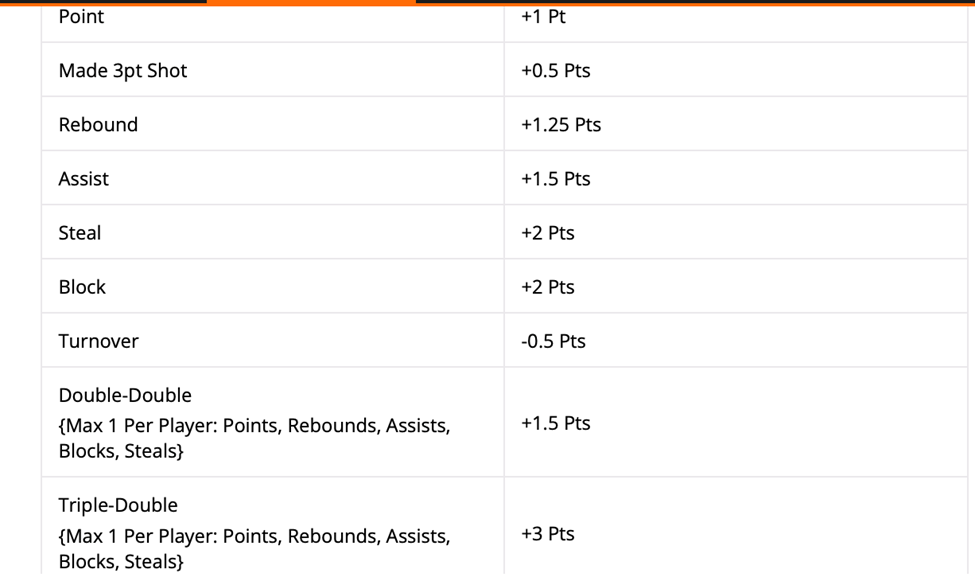


We calculated these up where we loaded our data. You can take a look at that code if you'd like to know how it's done.

In [ ]:
model.obj_func = pe.Objective(
    expr=sum(master_df_q1.loc[i, 'Total Fantasy Points'] * model.x[i] for i in DV_indexes),
    sense=pe.maximize)

#Solve the Model

At this point, we are doing nothing other than executing our masterplan.

In [ ]:
opt = pe.SolverFactory('glpk')
result = opt.solve(model)
print(result.solver.status, result.solver.termination_condition)

ok optimal


#Optimal Objective Value for Problem A

Our Optimal Objective Value is of 13,342 points. This means our model found a solution (or a team) that can get us 13,342 points!

This is total points across all games. If you want to find out how many points you make per game we simply just divide this number by the amount of games so far this season. However, since this problem is asking us to use historical data, let's leave it like this.

In [ ]:
# Access the value of the objective function after solving the model
obj_val = model.obj_func.expr()
print(f'Optimal objective value (maximum fantasy points) = {obj_val:.0f}')

Optimal objective value (maximum fantasy points) = 13342


#Optimal Lineup

To print the lineup, this code segment takes the solution from the optimization model and translates it into the lineup of players for our team. It ensure the players are correctly indexed for easy access, selects players based on the optimization outcome, retreives their detailed stats, and displays it all in a final roster.

This is the team that will get us out of the last place in the league and save us from ruining our reputation within the Denver Metropolitan Area comedy scene.



In [ ]:
# Ensure 'Player' column is the DataFrame index if it isn't already
if master_df_q1.index.name != 'Player':
    master_df_q1.set_index('Player', inplace=True)

# Correcting the way to access the value of Pyomo variables
selected_player_names = [player for player in master_df_q1.index if model.x[player].value == 1]

# Use the selected player names to access their details
selected_player_details = master_df_q1.loc[selected_player_names, ['Pos', 'MP', 'PTS', '3P', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'Salary', 'Position', 'Total Fantasy Points']]

print("Optimal Lineup:")
print(selected_player_details.to_string())


Optimal Lineup:
                   Pos    MP   PTS   3P  TRB  AST  STL  BLK  TOV  Salary Position  Total Fantasy Points
Player                                                                                                 
DeMar DeRozan       SF  1996  1202   49  216  278   61   33   80    7600    SF/PF               2061.50
Chet Holmgren        C  1624   903   90  409  144   38  143   88    7300        C               1993.25
Michael Porter Jr.  SF  1709   861  146  373   78   24   39   59    6500    SF/PF               1613.75
Derrick White       SG  1646   794  136  199  241   51   59   83    6400    PG/SG               1650.75
Fred VanVleet       PG  1727   775  135  176  385   52   46   75    6700       PG               1798.50
Dennis Schroder     PG  1635   726   82  151  329   46    8   89    4900    PG/SG               1512.75
Max Strus           SF  1710   645  127  262  196   48   24   77    4900    SG/SF               1435.50
Grayson Allen       SG  1612   628  123  193  15

#Problem B

The second problem will involve selecting the optimal lineup based on how the players performed during their actual games (i.e., the “cheat code” if you had it prior to selecting your lineup.

Unlike Problem A, we will use the Feb22NBAStats dataset to pull data needed to solve this problem.

#Question 2 Data

This is where we pull the necessary data and perform our fantasy points calculation.

In [ ]:
# Calculate fantasy points in df_FebStats
df_FebStats['FantasyPoints'] = (
    df_FebStats['PTS'] * 1 +
    (df_FebStats['TRB']) * 1.25 +
    df_FebStats['AST'] * 1.5 +
    df_FebStats['STL'] * 2 +
    df_FebStats['BLK'] * 2 +
    df_FebStats['TOV'] * (-0.5)
)

# Normalize player names in df_DKSalaries to ensure consistency for merging
df_DKSalaries['Name'] = df_DKSalaries['Name'].apply(lambda x: unicodedata.normalize('NFKD', x).encode('ascii', 'ignore').decode('ascii'))

# Merge df_FebStats with df_DKSalaries on normalized player names
master_df_q2 = pd.merge(
    df_FebStats[['Player', 'Team', 'FantasyPoints']],
    df_DKSalaries[['Name', 'Salary', 'Position', 'AvgPointsPerGame']],
    left_on='Player',
    right_on='Name'
)

# Drop duplicate column after merge
master_df_q2.drop(columns=['Name'], inplace=True)

More debugging. How fun!

In [ ]:
# Check if 'Player' is already the index, if not, set it as the index
if 'Player' in master_df_q2.columns:
    master_df_q2.set_index('Player', inplace=True)

#Create Model

Let's set up our whiteboard!

In [ ]:
model = pe.ConcreteModel()

#Decision Variables

Let's establish our script to choose which players we want and which ones we don't based off the Feb. 22 games!

In [ ]:
DV_indexes = set(master_df_q2.index)
model.x = pe.Var(DV_indexes, domain=pe.Binary)

#Objective Function

Let's pick the players that fit our needs the best.

In [ ]:
model.obj_func = pe.Objective(
    expr=sum(master_df_q2.loc[player, 'FantasyPoints'] * model.x[player] for player in DV_indexes),
    sense=pe.maximize
)

#Constraints
We have the same rules for this problem, with the exception of the Minutes Played rule we added to our first problem. We don't need that here.

In [ ]:
model.salary_cap = pe.Constraint(expr=sum(master_df_q2.loc[player, 'Salary'] * model.x[player] for player in DV_indexes) <= 50000)

model.team_size = pe.Constraint(expr=sum(model.x[player] for player in DV_indexes) == 8)


# PG
model.PG_constraint = pe.Constraint(expr=sum(model.x[player] for player in DV_indexes if 'PG' in master_df_q2.loc[player, 'Position']) >= 1)

# SG
model.SG_constraint = pe.Constraint(expr=sum(model.x[player] for player in DV_indexes if 'SG' in master_df_q2.loc[player, 'Position']) >= 1)

# SF
model.SF_constraint = pe.Constraint(expr=sum(model.x[player] for player in DV_indexes if 'SF' in master_df_q2.loc[player, 'Position']) >= 1)

# PF
model.PF_constraint = pe.Constraint(expr=sum(model.x[player] for player in DV_indexes if 'PF' in master_df_q2.loc[player, 'Position']) >= 1)

# C
model.C_constraint = pe.Constraint(expr=sum(model.x[player] for player in DV_indexes if 'C' in master_df_q2.loc[player, 'Position']) >= 1)


#Solve the Model

Let's execute our masterplan once again!

In [ ]:
opt = pe.SolverFactory('glpk')
result = opt.solve(model)
print(result.solver.status, result.solver.termination_condition)

ok optimal


#Optimal Objective Value for Problem B

For today's games (Feb. 22), we will get 369 points if we choose the team our model found to be the most optimal.

In [ ]:
# Access the value of the objective function after solving the model
obj_val = model.obj_func.expr()
print(f'Optimal objective value (maximum fantasy points) = {obj_val:.0f}')

Optimal objective value (maximum fantasy points) = 369


#Optimal Lineup

Let's take a look at our dream team for Feb. 22!

In [ ]:
# Extract the selected players' names
selected_player_names = [player for player in master_df_q2.index if pe.value(model.x[player]) == 1]

# Display the selected players' details
selected_player_details = master_df_q2.loc[selected_player_names]
print(selected_player_details.to_string())

                  Team  FantasyPoints  Salary Position  AvgPointsPerGame
Player                                                                  
Luka Doncic        DAL          73.25   12100       PG             65.18
Kyle Kuzma         WAS          55.00    7400     PF/C             38.35
Derrick White      BOS          48.25    6400    PG/SG             32.46
Moritz Wagner      ORL          32.75    3300     PF/C             19.74
Jonas Valanciunas  NOP          43.50    6400        C             32.26
Herbert Jones      NOP          42.75    4600    SF/PF             23.46
T.J. McConnell     IND          36.50    4100       PG             21.54
Ausar Thompson     DET          37.25    5000    SF/PF             22.83


#Conclusion

Now that we have both teams lined up, let's do a brief assessment based on what our assignments asked for:

For Question 1: Historical Data Based Lineup

- Salary Cap: Even though is not explicitely calculated, the salary for Part A is exactly $50,000 which meet our requirement in salary cap.
- Positional Requirements: The lineup includes a mix of positions (SF, C, SG, PG), and specific positions like SF/PF and PG/SG indicate flexibility, fitting typical fantasy basketball requirements.
- Optimization for Fantasy Points: The lineup is optimized for the highest possible total fantasy points within the given constraints, as indicated by the "Total Fantasy Points" column.

For Question 2: Actual Game Performance Based Lineup

- Salary Cap and Team Size: The salary total for this team is about $49,300. This meets our salary constraint.
- Positional Requirements and Flexibility: Similar to the first lineup, there's a good mix of positions, including eligibility for multiple positions (PF/C, SF/PF), which is beneficial for fitting into DraftKings' flexible roster slots.
- Optimization for Fantasy Points: The lineup prioritizes players with high fantasy points from specific games, indicating it was optimized based on actual game performance, potentially leveraging the "cheat code" aspect of knowing outcomes in advance.

#Appendix

I decided to hone my AGI skill and try to get a lot of this project done through proper AI prompting. A lot of this code was generated by ChatGPT (the data cleaning steps, debugging, and lineup printing statements are taken directly), as well as the data frames of what data I needed for each question since I've never thought about just putting all the needed data into one dataframe and using that instead of 3 or 4 different dataframes.

It took a long time to get this done, but being patient paid off in the end. I tried to make the code look similar to what we've done, and most of it is pretty readable and is not hard to understand what is happening. This is probably due to the simplicity (to a certain extent) of the constraints we were given. The rest is exactly what we've done throughout this course: Loading in data, setting up and solving the model, printing the optimal solution, etc.

Unfortunately, some of my prompts included screenshots of issues, dataframes, and other aspects of the code that prevent the conversation from being shared since OpenAI doesn't support sharing with images yet. However, I saved the conversation and if you want to look at it please email me at Manuel.Sales@du.edu.

The AI itself helped me come up with the extra constraint in Problem A. Additionally, I realized it did not do the last given constraint about UTIL players. I asked about it and it said that you indirectly meet this constraints through the rest of the position constraints. I compared my constraints to other classmates and they had a completely different approach. Many split players with more than 1 position into two different ones, which I believe forced to create that last constraint. My lineups displayed players that were able to meet this constraint without having to explicitely declare it, which I think is interesting if is correct.

I also realized the approach to loading data into a master dataframe is genius. It makes everything easier to keep track of. I often found myself struggling to reference the right DFs during our exercises in class, but with this approach I never had to worry about it because all the needed data was inside this master dataframe.

##New ChatGPT Prompt:

To not leave this appendix empty handed from wonderful chatGPT conversations, I prompted the AI again and this is the result:

https://chat.openai.com/share/401492a8-0efa-4e82-9d06-f0bcbe89069f

Further prompting will be needed since the AI does not generate the entire code that is needed to solve the problem.


In [ ]:
%%shell
jupyter nbconvert --to html ///content/Final_Project.ipynb

[NbConvertApp] Converting notebook ///content/Final_Project.ipynb to html
[NbConvertApp] Writing 850011 bytes to /content/Final_Project.html
